<a target="_blank" href="https://github.com/Techtonique/nnetsauce/blob/master/nnetsauce/demo/thierrymoudiki_2024-11-24_nnetsauce-sktime-LLM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this post:

- I show how to use python package `nnetsauce` alongside `sktime` for univariate and multivariate time series (probabilistic) forecasting. `sktime` useful for benchmarking a plethora of (probabilistic) forecasts with a unified interface

- I benchmark [`nnetsauce.MTS`](https://www.researchgate.net/publication/382589729_Probabilistic_Forecasting_with_nnetsauce_using_Density_Estimation_Bayesian_inference_Conformal_prediction_and_Vine_copulas)'s _armada_ against foundation models ("LLMs", Amazon's _Chronos_, IBM's TinyTimeMixer) and _statistical_ models. Regarding the LLMs: If I'm not doing it well (I just _plugged and played_), do not hesitate to reach out.  

# 0 - Install `nnetsauce` and `mlsauce`

In [ ]:
!pip install git+https://github.com/Techtonique/mlsauce.git --verbose

In [ ]:
!pip install nnetsauce

## 1 - Example 1: using [`nnetsauce`]() with sktime

In [ ]:
!pip install git+https://github.com/thierrymoudiki/sktime.git --upgrade --no-cache-dir

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn import linear_model
from statsmodels.tsa.base.datetools import dates_from_str
from sktime.forecasting.nnetsaucemts import NnetsauceMTS

Macroeconomic data

In [ ]:
# some example data
mdata = sm.datasets.macrodata.load_pandas().data
# prepare the dates index
dates = mdata[["year", "quarter"]].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
mdata = mdata[["realgovt", "tbilrate", "cpi"]]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()
data2 = mdata

n = data.shape[0]
max_idx_train = np.floor(n * 0.9)
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n)
df_train = data.iloc[training_index, :]
print(df_train.tail())
df_test = data.iloc[testing_index, :]
print(df_test.head())

            realgovt  tbilrate       cpi
2003-06-30  0.047086 -0.171850  0.002726
2003-09-30  0.000981 -0.021053  0.006511
2003-12-31  0.007267 -0.043485  0.007543
2004-03-31  0.012745  0.043485  0.005887
2004-06-30  0.005669  0.252496  0.009031
            realgovt  tbilrate       cpi
2004-09-30  0.017200  0.297960  0.008950
2004-12-31 -0.012387  0.299877  0.005227
2005-03-31  0.004160  0.201084  0.010374
2005-06-30  0.000966  0.112399  0.004633
2005-09-30  0.023120  0.156521  0.022849


In [ ]:
n2 = data.shape[0]
max_idx_train2 = np.floor(n2 * 0.9)
training_index2 = np.arange(0, max_idx_train2)
testing_index2 = np.arange(max_idx_train2, n2)
df_train2 = data2.iloc[training_index2, :]
print(df_train2.tail())
df_test2 = data2.iloc[testing_index, :]
print(df_test.head())

            realgovt  tbilrate    cpi
2003-03-31   800.196      1.14  183.2
2003-06-30   838.775      0.96  183.7
2003-09-30   839.598      0.94  184.9
2003-12-31   845.722      0.90  186.3
2004-03-31   856.570      0.94  187.4
            realgovt  tbilrate       cpi
2004-09-30  0.017200  0.297960  0.008950
2004-12-31 -0.012387  0.299877  0.005227
2005-03-31  0.004160  0.201084  0.010374
2005-06-30  0.000966  0.112399  0.004633
2005-09-30  0.023120  0.156521  0.022849


### 1 - 1 Point forecast with `nnetsauce`'s `sktime` interface

In [ ]:
regr = linear_model.RidgeCV()

obj_MTS = NnetsauceMTS(regr, lags = 20, n_hidden_features=7, n_clusters=2,
                       type_pi="scp2-block-bootstrap",
                       kernel="gaussian",
                       replications=250)
obj_MTS.fit(df_train)

res = obj_MTS.predict(fh=[i for i in range(1, 20)])

print(res)

100%|██████████| 3/3 [00:00<00:00, 121.23it/s]

            realgovt  tbilrate  cpi
date                               
2004-09-30      0.01      0.02 0.02
2004-12-31      0.01      0.04 0.02
2005-03-31      0.00      0.03 0.02
2005-06-30      0.01      0.02 0.02
2005-09-30      0.01      0.01 0.02
2005-12-31      0.01      0.04 0.03
2006-03-31      0.01      0.03 0.02
2006-06-30      0.01      0.03 0.03
2006-09-30      0.01      0.02 0.02
2006-12-31      0.01      0.00 0.02
2007-03-31      0.01     -0.00 0.02
2007-06-30      0.01      0.02 0.02
2007-09-30      0.01     -0.01 0.02
2007-12-31      0.00     -0.01 0.02
2008-03-31      0.01      0.02 0.02
2008-06-30      0.00      0.03 0.02
2008-09-30      0.00      0.03 0.02
2008-12-31      0.00      0.01 0.02
2009-03-31      0.00     -0.00 0.02


### 1 - 2 Probabilistic forecasting with `nnetsauce`'s `sktime` interface

In [ ]:
res = obj_MTS.predict_quantiles(fh=[i for i in range(1, 20)],
                                alpha=0.05)

print(res)

           realgovt tbilrate   cpi realgovt tbilrate  cpi
               0.05     0.05  0.05     0.95     0.95 0.95
date                                                     
2004-09-30    -0.03    -0.47  0.01     0.07     0.44 0.04
2004-12-31    -0.03    -0.31  0.01     0.06     0.66 0.04
2005-03-31    -0.04    -0.41  0.00     0.06     0.65 0.04
2005-06-30    -0.03    -0.43  0.01     0.06     0.46 0.04
2005-09-30    -0.03    -0.44  0.01     0.06     0.37 0.04
2005-12-31    -0.03    -0.30  0.01     0.06     0.46 0.04
2006-03-31    -0.03    -0.40  0.01     0.06     0.46 0.04
2006-06-30    -0.03    -0.40  0.01     0.06     0.46 0.04
2006-09-30    -0.03    -0.31  0.01     0.06     0.66 0.04
2006-12-31    -0.03    -0.44  0.00     0.05     0.61 0.04
2007-03-31    -0.03    -0.44  0.01     0.05     0.37 0.04
2007-06-30    -0.04    -0.31  0.01     0.05     0.37 0.04
2007-09-30    -0.03    -0.31  0.01     0.06     0.36 0.04
2007-12-31    -0.04    -0.44  0.01     0.05     0.59 0.04
2008-03-31    

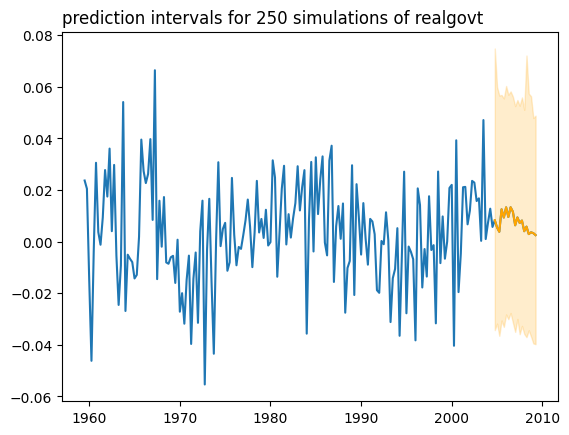

In [ ]:
obj_MTS.fitter.plot(series="realgovt")

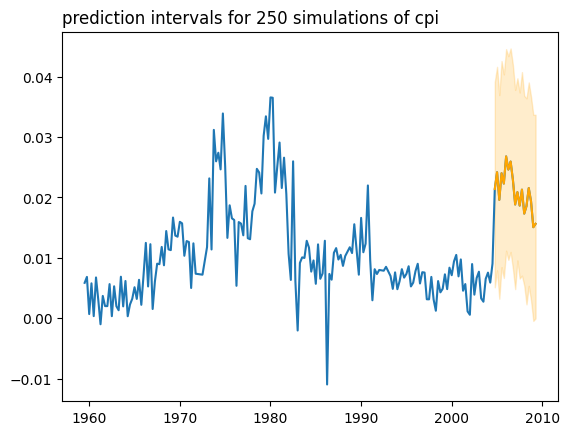

In [ ]:
obj_MTS.fitter.plot(series="cpi")

# 2 - sktime foundation models and nnetsauce

### 2 - 1 - Example1 on macroeconomic data

In [ ]:
# Do imports
import nnetsauce as ns
import mlsauce as ms
from sktime.forecasting.ttm import TinyTimeMixerForecaster
from sktime.forecasting.chronos import ChronosForecaster

# Initialise models
chronos = ChronosForecaster("amazon/chronos-t5-tiny")
ttm = TinyTimeMixerForecaster()
regr = linear_model.RidgeCV()
obj_MTS = NnetsauceMTS(regr, lags = 20, n_hidden_features=7, n_clusters=2,
                       type_pi="scp2-block-bootstrap",
                       kernel="gaussian",
                       replications=250)
regr2 = ms.GenericBoostingRegressor(regr)
obj_MTS2 = ns.MTS(obj=regr2)

# Fit
h = df_test.shape[0] + 1
chronos.fit(y=df_train, fh=range(1, h))
ttm.fit(y=df_train, fh=range(1, h))
obj_MTS.fit(y=df_train, fh=range(1, h))
obj_MTS2.fit(df_train)

# Predict
pred_chronos = chronos.predict(fh=[i for i in range(1, h)])
pred_ttm = ttm.predict(fh=[i for i in range(1, h)])
pred_MTS = obj_MTS.predict(fh=[i for i in range(1, h)])
pred_MTS2 = obj_MTS2.predict(h=h-1)

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


In [ ]:
pred_MTS2 = obj_MTS2.predict(h=h-1)

In [ ]:
import numpy as np

def rmse(predictions, targets):
    return np.sqrt(((predictions.values - targets.values) ** 2).mean())

def mae(predictions, targets):
    return np.mean(np.abs(predictions - targets))

def me(predictions, targets):
    return np.mean(predictions - targets)

In [ ]:
print("Chronos RMSE:", rmse(df_test, pred_chronos))
print("Chronos MAE:", mae(df_test, pred_chronos))
print("Chronos ME:", me(df_test, pred_chronos))

print("TinyTimeMixer RMSE:", rmse(df_test, pred_ttm))
print("TinyTimeMixer MAE:", mae(df_test, pred_ttm))
print("TinyTimeMixer ME:", me(df_test, pred_ttm))

print("NnetsauceMTS RMSE:", rmse(df_test, pred_MTS))
print("NnetsauceMTS MAE:", mae(df_test, pred_MTS))
print("NnetsauceMTS ME:", me(df_test, pred_MTS))

Chronos RMSE: 0.3270528840422444
Chronos MAE: 0.10750380038506846
Chronos ME: -0.04182334654432299
TinyTimeMixer RMSE: 0.3248244141056522
TinyTimeMixer MAE: 0.11031492439459516
TinyTimeMixer ME: -0.03476608913007449
NnetsauceMTS RMSE: 0.320951903060047
NnetsauceMTS MAE: 0.10903099364744497
NnetsauceMTS ME: -0.0298461588803314


**Loop and leaderboard**

In [ ]:
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from tqdm import tqdm

results = []

results.append(["Chronos", rmse(df_test, pred_chronos), mae(df_test, pred_chronos), me(df_test, pred_chronos)])
results.append(["TinyTimeMixer", rmse(df_test, pred_ttm), mae(df_test, pred_ttm), me(df_test, pred_ttm)])
results.append(["NnetsauceMTS", rmse(df_test, pred_MTS), mae(df_test, pred_MTS), me(df_test, pred_MTS)])

# statistical models
for i, name in enumerate(["ARIMA", "ETS", "Theta", "VAR", "VECM"]):
  try:
    regr = ns.ClassicalMTS(model=name)
    regr.fit(df_train)
    X_pred = regr.predict(h=df_test.shape[0])
    results.append([name, rmse(df_test, X_pred.mean), mae(df_test, X_pred.mean), me(df_test, X_pred.mean)])
  except Exception:
    pass

for est in tqdm(all_estimators()):
  if (issubclass(est[1], RegressorMixin)):
    try:
      preds = ns.MTS(est[1](), verbose=0, show_progress=False).\
      fit(df_train).\
      predict(h=df_test.shape[0])
      results.append([est[0], rmse(df_test, preds), mae(df_test, preds), me(df_test, preds)])
    except Exception:
      pass

100%|██████████| 206/206 [00:06<00:00, 29.81it/s]


In [ ]:
results_df = pd.DataFrame(results, columns=["model", "rmse", "mae", "me"])

In [ ]:
import pandas as pd

# Assuming 'results_df' is the DataFrame from the provided code
pd.options.display.float_format = '{:.5f}'.format
display(results_df.sort_values(by="rmse"))

,model,rmse,mae,me
7,BaggingRegressor,0.30560,0.10120,-0.03167
14,ExtraTreeRegressor,0.31035,0.11071,-0.03677
15,ExtraTreesRegressor,0.32077,0.11472,-0.02632
2,NnetsauceMTS,0.32095,0.10903,-0.02985
29,LinearRegression,0.32154,0.10754,-0.03336
50,TransformedTargetRegressor,0.32154,0.10754,-0.03336
45,Ridge,0.32168,0.10821,-0.03250
21,KernelRidge,0.32168,0.10821,-0.03250
46,RidgeCV,0.32262,0.10881,-0.03281
20,KNeighborsRegressor,0.32315,0.10933,-0.03600


In [ ]:
display(results_df.sort_values(by="mae"))

,model,rmse,mae,me
7,BaggingRegressor,0.30560,0.10120,-0.03167
0,Chronos,0.32705,0.10750,-0.04182
50,TransformedTargetRegressor,0.32154,0.10754,-0.03336
29,LinearRegression,0.32154,0.10754,-0.03336
44,RandomForestRegressor,0.32501,0.10802,-0.03557
45,Ridge,0.32168,0.10821,-0.03250
21,KernelRidge,0.32168,0.10821,-0.03250
46,RidgeCV,0.32262,0.10881,-0.03281
2,NnetsauceMTS,0.32095,0.10903,-0.02985
35,MultiTaskLassoCV,0.32324,0.10931,-0.03319


In [ ]:
display(results_df.sort_values(by="me", ascending=False))

,model,rmse,mae,me
31,MLPRegressor,2640594432241.43555,711026457838.45886,540623410390.19354
16,GaussianProcessRegressor,0.34571,0.15000,0.01448
15,ExtraTreesRegressor,0.32077,0.11472,-0.02632
17,GradientBoostingRegressor,0.32657,0.11299,-0.02783
36,NuSVR,0.32666,0.11333,-0.02833
18,HistGradientBoostingRegressor,0.32629,0.11244,-0.02872
2,NnetsauceMTS,0.32095,0.10903,-0.02985
19,HuberRegressor,0.32643,0.11203,-0.03014
6,AdaBoostRegressor,0.32669,0.11199,-0.03032
47,SGDRegressor,0.32665,0.11173,-0.03125


### 2 - 2 - Example2 on antidiabetic drug sales

In [ ]:
url = "https://raw.githubusercontent.com/Techtonique/"
url += "datasets/main/time_series/univariate/"
url += "a10.csv"
data = pd.read_csv(url)
data.index = pd.DatetimeIndex(data.date) # must have
data.drop(columns=['date'], inplace=True)

In [ ]:
n = data.shape[0]
max_idx_train = np.floor(n * 0.9)
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n)
df_train = data.iloc[training_index, :]
print(df_train.tail())
df_test = data.iloc[testing_index, :]
print(df_test.head())

              value
date               
2006-05-01 17.78306
2006-06-01 16.29160
2006-07-01 16.98028
2006-08-01 18.61219
2006-09-01 16.62334
              value
date               
2006-10-01 21.43024
2006-11-01 23.57552
2006-12-01 23.33421
2007-01-01 28.03838
2007-02-01 16.76387


<Axes: xlabel='date'>

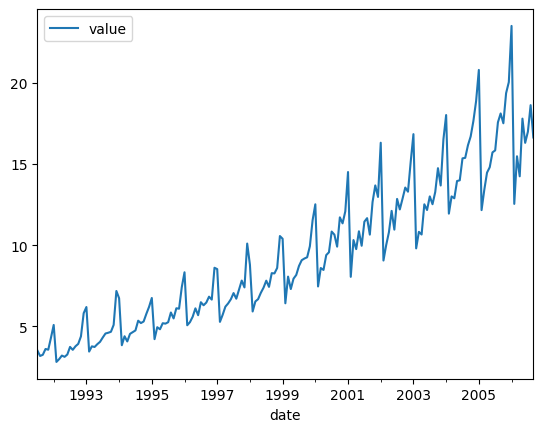

In [ ]:
df_train.plot()

In [ ]:
# Do imports
import nnetsauce as ns
import mlsauce as ms
from sktime.forecasting.ttm import TinyTimeMixerForecaster
from sktime.forecasting.chronos import ChronosForecaster

# Initialise models
chronos = ChronosForecaster("amazon/chronos-t5-tiny")
ttm = TinyTimeMixerForecaster()
regr = linear_model.RidgeCV()
regr2 = ms.GenericBoostingRegressor(regr)
obj_MTS2 = ns.MTS(obj=regr2)

# Fit
h = df_test.shape[0] + 1
chronos.fit(y=df_train, fh=range(1, h))
ttm.fit(y=df_train, fh=range(1, h))
obj_MTS.fit(y=df_train, fh=range(1, h))
obj_MTS2.fit(df_train)

# Predict
pred_chronos = chronos.predict(fh=[i for i in range(1, h)])
pred_ttm = ttm.predict(fh=[i for i in range(1, h)])
pred_MTS2 = obj_MTS2.predict(h=h-1)

100%|██████████| 100/100 [00:00<00:00, 327.48it/s]


In [ ]:
print("Chronos RMSE:", rmse(df_test, pred_chronos))
print("Chronos MAE:", mae(df_test, pred_chronos))
print("Chronos ME:", me(df_test, pred_chronos))

print("TinyTimeMixer RMSE:", rmse(df_test, pred_ttm))
print("TinyTimeMixer MAE:", mae(df_test, pred_ttm))
print("TinyTimeMixer ME:", me(df_test, pred_ttm))

print("NnetsauceMTS RMSE:", rmse(df_test, pred_MTS2))
print("NnetsauceMTS MAE:", mae(df_test, pred_MTS2))
print("NnetsauceMTS ME:", me(df_test, pred_MTS2))

Chronos RMSE: 4.668968548036785
Chronos MAE: 4.351116104707961
Chronos ME: 3.249815388190104
TinyTimeMixer RMSE: 6.6643723494125355
TinyTimeMixer MAE: 5.881109575050688
TinyTimeMixer ME: 5.876180504854445
NnetsauceMTS RMSE: 7.449155397775451
NnetsauceMTS MAE: 6.717429133757641
NnetsauceMTS ME: 6.717429133757641


In [ ]:
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from tqdm import tqdm

results = []

# LLMs and sktime
results.append(["Chronos", rmse(df_test, pred_chronos), mae(df_test, pred_chronos), me(df_test, pred_chronos)])
results.append(["TinyTimeMixer", rmse(df_test, pred_ttm), mae(df_test, pred_ttm), me(df_test, pred_ttm)])
results.append(["NnetsauceMTS", rmse(df_test, pred_MTS), mae(df_test, pred_MTS), me(df_test, pred_MTS)])

# statistical models
for i, name in enumerate(["ARIMA", "ETS", "Theta", "VAR", "VECM"]):
  try:
    regr = ns.ClassicalMTS(model=name)
    regr.fit(df_train)
    X_pred = regr.predict(h=df_test.shape[0])
    results.append([name, rmse(df_test, X_pred.mean), mae(df_test, X_pred.mean), me(df_test, X_pred.mean)])
  except Exception:
    pass

for est in tqdm(all_estimators()):
  if (issubclass(est[1], RegressorMixin)):
    try:
      preds = ns.MTS(est[1](), lags=20, verbose=0, show_progress=False).\
      fit(df_train).\
      predict(h=df_test.shape[0])
      results.append([est[0], rmse(df_test, preds), mae(df_test, preds), me(df_test, preds)])
    except Exception:
      pass

100%|██████████| 206/206 [00:05<00:00, 35.10it/s]


In [ ]:
results_df = pd.DataFrame(results, columns=["model", "rmse", "mae", "me"])

In [ ]:
import pandas as pd

# Assuming 'results_df' is the DataFrame from the provided code
pd.options.display.float_format = '{:.5f}'.format
display(results_df.sort_values(by="rmse"))

,model,rmse,mae,me
37,OrthogonalMatchingPursuit,3.04709,2.69552,2.59578
43,RandomForestRegressor,3.10382,2.55888,2.05839
38,OrthogonalMatchingPursuitCV,3.12691,2.68994,2.67753
25,LassoCV,3.14258,2.78649,2.71682
35,MultiTaskLassoCV,3.14258,2.78649,2.71682
27,LassoLarsCV,3.14308,2.78698,2.71755
23,LarsCV,3.14308,2.78698,2.71755
33,MultiTaskElasticNetCV,3.17701,2.84284,2.77308
13,ElasticNetCV,3.17701,2.84284,2.77308
46,SGDRegressor,3.22877,2.83957,2.83957


In [ ]:
display(results_df.sort_values(by="mae"))

,model,rmse,mae,me
43,RandomForestRegressor,3.10382,2.55888,2.05839
38,OrthogonalMatchingPursuitCV,3.12691,2.68994,2.67753
37,OrthogonalMatchingPursuit,3.04709,2.69552,2.59578
10,DecisionTreeRegressor,3.26890,2.73450,2.15218
14,ExtraTreeRegressor,3.49769,2.77511,2.41475
25,LassoCV,3.14258,2.78649,2.71682
35,MultiTaskLassoCV,3.14258,2.78649,2.71682
27,LassoLarsCV,3.14308,2.78698,2.71755
23,LarsCV,3.14308,2.78698,2.71755
8,BaggingRegressor,3.27914,2.83882,2.50350


In [ ]:
display(results_df.sort_values(by="me"))

,model,rmse,mae,me
40,PassiveAggressiveRegressor,5.89234,4.31086,-4.31086
31,MLPRegressor,3.65081,2.91033,1.08975
43,RandomForestRegressor,3.10382,2.55888,2.05839
10,DecisionTreeRegressor,3.26890,2.73450,2.15218
14,ExtraTreeRegressor,3.49769,2.77511,2.41475
8,BaggingRegressor,3.27914,2.83882,2.50350
37,OrthogonalMatchingPursuit,3.04709,2.69552,2.59578
38,OrthogonalMatchingPursuitCV,3.12691,2.68994,2.67753
15,ExtraTreesRegressor,3.30520,2.89079,2.71086
25,LassoCV,3.14258,2.78649,2.71682
